In [1]:
import tensorcircuit as tc
import torch

from utils import maxcut_hamil_diag, two_qubit_rotations, single_y_rotation, xqaoa, ihva_from_graph, get_circuit, expected_min_of_N_samples, optimality_ratio
from qite_vqe import QITE_VQE

import networkx as nx

import json

tc.set_backend('pytorch')

Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module


pytorch_backend

# Settings

## Problem

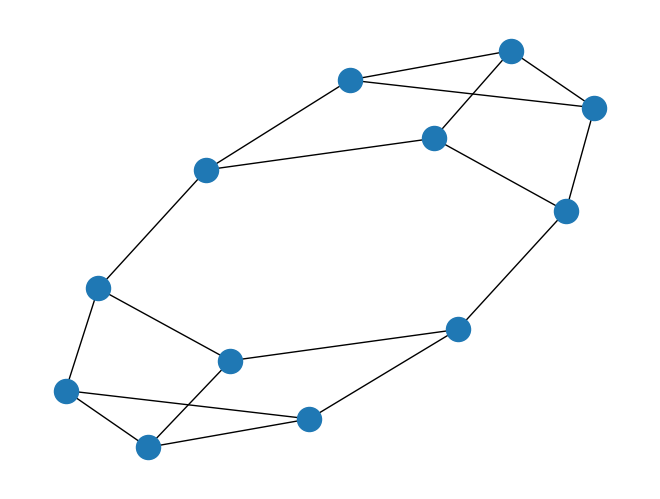

In [2]:
graph = 'reg3' # reg3, reg4, ..., gnp1w, gnp2w,...
size = 12
idx = 0

edges = json.load(open('maxcut_problems.json', 'r'))[str(graph)][str(size)][idx]
G = nx.from_edgelist(edges)
nx.draw(G)

## Hamiltonian

In [3]:
hamil_diag = torch.tensor(maxcut_hamil_diag(edges), dtype=torch.float32)
print(hamil_diag.shape)

torch.Size([4096])


2025-04-13 06:21:02.718279: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-04-13 06:21:02.718291: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-04-13 06:21:02.718298: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-04-13 06:21:02.718319: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-13 06:21:02.718330: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Ansatz (operation/pauli string)

In [4]:
# operations = single_y_rotation(size) # P1A
# operations = single_y_rotation(size) + two_qubit_rotations(size,['ZY','XY','YZ','YX']) # P2A
operations = single_y_rotation(size) + two_qubit_rotations(size,['ZY','YZ']) # P2A-ZY
# operations = single_y_rotation(size) + two_qubit_rotations(size,['XY','YX']) # P2A-XY
# operations = xqaoa(G,'M') # XQAOA with X+Y mixer
# operations = ihva_from_graph(G) # iHVA

print(operations)

['Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10', 'Y11', 'Z0_Y9', 'Z1_Y8', 'Z2_Y7', 'Z3_Y6', 'Z4_Y5', 'Z10_Y11', 'Y0_Z9', 'Y1_Z8', 'Y2_Z7', 'Y3_Z6', 'Y4_Z5', 'Y10_Z11', 'Z10_Y8', 'Z0_Y7', 'Z1_Y6', 'Z2_Y5', 'Z3_Y4', 'Z9_Y11', 'Y10_Z8', 'Y0_Z7', 'Y1_Z6', 'Y2_Z5', 'Y3_Z4', 'Y9_Z11', 'Z9_Y7', 'Z10_Y6', 'Z0_Y5', 'Z1_Y4', 'Z2_Y3', 'Z8_Y11', 'Y9_Z7', 'Y10_Z6', 'Y0_Z5', 'Y1_Z4', 'Y2_Z3', 'Y8_Z11', 'Z8_Y6', 'Z9_Y5', 'Z10_Y4', 'Z0_Y3', 'Z1_Y2', 'Z7_Y11', 'Y8_Z6', 'Y9_Z5', 'Y10_Z4', 'Y0_Z3', 'Y1_Z2', 'Y7_Z11', 'Z7_Y5', 'Z8_Y4', 'Z9_Y3', 'Z10_Y2', 'Z0_Y1', 'Z6_Y11', 'Y7_Z5', 'Y8_Z4', 'Y9_Z3', 'Y10_Z2', 'Y0_Z1', 'Y6_Z11', 'Z6_Y4', 'Z7_Y3', 'Z8_Y2', 'Z9_Y1', 'Z10_Y0', 'Z5_Y11', 'Y6_Z4', 'Y7_Z3', 'Y8_Z2', 'Y9_Z1', 'Y10_Z0', 'Y5_Z11', 'Z5_Y3', 'Z6_Y2', 'Z7_Y1', 'Z8_Y0', 'Z9_Y10', 'Z4_Y11', 'Y5_Z3', 'Y6_Z2', 'Y7_Z1', 'Y8_Z0', 'Y9_Z10', 'Y4_Z11', 'Z4_Y2', 'Z5_Y1', 'Z6_Y0', 'Z7_Y10', 'Z8_Y9', 'Z3_Y11', 'Y4_Z2', 'Y5_Z1', 'Y6_Z0', 'Y7_Z10', 'Y8_Z9', 'Y3_Z11', 'Z3_Y1', 'Z4_Y0', 'Z5_Y10', '

## Initial state

In [5]:
# equal amplitude superposition
circ = tc.Circuit(size)
for i in range(size):
    circ.h(i)
# circ.h(0) # for P1A and P2A-XY
initial_state = circ.state()

## Initial Parameter

Set initial parameter for VQEs

In [6]:
initial_params = None # using 1-step QITE for initialization
# initial_params = torch.randn(len(operations)) # if using XQAOA, initial parameters are required

# Adaptive Weighted QITE-VQE

hyperparameters:

In [7]:
lr = 0.05 # learning rate
dt = lr # imaginary time step/ set to equal to lr
# weighting function settings:
lam = 1
mu = 0.9

In [8]:
awqv = QITE_VQE(num_qubits = size, hamil_diag = hamil_diag, operations = operations, initial_state = initial_state, mode = 'AWQV', dt = dt, lr = lr, lam = lam, mu = mu)
awqv.run(max_iter=50, display_interval=10)

iter 0: exp = -9.0000, approx = 0.5625, opt = 0.000488
iter 10: exp = -12.5169, approx = 0.7823, opt = 0.052565 (last_w = 0.0599)
iter 20: exp = -14.2667, approx = 0.8917, opt = 0.339078 (last_w = 0.2985)
iter 30: exp = -15.6056, approx = 0.9753, opt = 0.823219 (last_w = 0.3865)
iter 40: exp = -15.7570, approx = 0.9848, opt = 0.928998 (last_w = 0.7105)
iter 50: exp = -15.9871, approx = 0.9992, opt = 0.996214 (last_w = 1.0000)
best iter: 50, exp: -15.9871, approx: 0.9992, opt: 0.996214


# VQE

In [9]:
operations = ihva_from_graph(G)
lr = 0.05
vqe = QITE_VQE(num_qubits = size, hamil_diag = hamil_diag, operations = operations, initial_state = initial_state, mode = 'VQE', lr = lr)
vqe.run(max_iter=100, display_interval=20, initial_params = None)

iter 0: exp = -9.0000, approx = 0.5625, opt = 0.000488
iter 20: exp = -12.5596, approx = 0.7850, opt = 0.043299 (last_w = 1.0000)
iter 40: exp = -14.0740, approx = 0.8796, opt = 0.210718 (last_w = 1.0000)
iter 60: exp = -14.6679, approx = 0.9167, opt = 0.384888 (last_w = 1.0000)
iter 80: exp = -14.8881, approx = 0.9305, opt = 0.466590 (last_w = 1.0000)
iter 100: exp = -14.9588, approx = 0.9349, opt = 0.490866 (last_w = 1.0000)
best iter: 100, exp: -14.9588, approx: 0.9349, opt: 0.490866


# Compressed QITE (cQITE)

In [10]:
operations = single_y_rotation(size) + two_qubit_rotations(size,['ZY','YZ']) # P2A-ZY
dt = 0.05
cqite = QITE_VQE(num_qubits = size, hamil_diag = hamil_diag, operations = operations, initial_state = initial_state, mode = 'cQITE', dt = dt)
cqite.run(max_iter=50, display_interval=10)

iter 0: exp = -9.0000, approx = 0.5625, opt = 0.000488
iter 10: exp = -12.5321, approx = 0.7833, opt = 0.048085 (last_w = 0.0000)
iter 20: exp = -13.6196, approx = 0.8512, opt = 0.156287 (last_w = 0.0000)
iter 30: exp = -13.3411, approx = 0.8338, opt = 0.152598 (last_w = 0.0000)
iter 40: exp = -12.9921, approx = 0.8120, opt = 0.129582 (last_w = 0.0000)
iter 50: exp = -12.6485, approx = 0.7905, opt = 0.110041 (last_w = 0.0000)
best iter: 21, exp: -13.6231, approx: 0.8514, opt: 0.161538


# cQITE-initialized VQE (QIV)

In [11]:
initial_params = torch.tensor(cqite.parameters) # best parameters from cQITE
lr = 0.05
qiv = QITE_VQE(num_qubits = size, hamil_diag = hamil_diag, operations = operations, initial_state = initial_state, mode = 'VQE', lr = lr)
qiv.run(max_iter= 50 - cqite.best_iter + 1, display_interval= 5, initial_params = initial_params)
# iter 0 -> initial state
# iter 1 -> parameterized state with parameters from cQITE

iter 0: exp = -9.0000, approx = 0.5625, opt = 0.000488
iter 5: exp = -14.0358, approx = 0.8772, opt = 0.252043 (last_w = 1.0000)
iter 10: exp = -14.3541, approx = 0.8971, opt = 0.348605 (last_w = 1.0000)
iter 15: exp = -14.6361, approx = 0.9148, opt = 0.446130 (last_w = 1.0000)
iter 20: exp = -14.9354, approx = 0.9335, opt = 0.556721 (last_w = 1.0000)
iter 25: exp = -15.2359, approx = 0.9522, opt = 0.676771 (last_w = 1.0000)
iter 30: exp = -15.4887, approx = 0.9680, opt = 0.786147 (last_w = 1.0000)
best iter: 30, exp: -15.4887, approx: 0.9680, opt: 0.786147


# QITE

In [12]:
operations = single_y_rotation(size) + two_qubit_rotations(size,['ZY','XY','YZ','YX']) # P2A
dt = 0.05
qite = QITE_VQE(num_qubits = size, hamil_diag = hamil_diag, operations = operations, initial_state = initial_state, mode = 'QITE', dt = dt)
qite.run(max_iter= 50, display_interval= 10)

iter 0: exp = -9.0000, approx = 0.5625, opt = 0.000488
iter 10: exp = -12.8048, approx = 0.8003, opt = 0.068343 (last_w = 0.0000)
iter 20: exp = -14.5672, approx = 0.9105, opt = 0.387735 (last_w = 0.0000)
iter 30: exp = -14.9594, approx = 0.9350, opt = 0.575160 (last_w = 0.0000)
iter 40: exp = -15.0832, approx = 0.9427, opt = 0.645816 (last_w = 0.0000)
iter 50: exp = -15.1270, approx = 0.9454, opt = 0.669591 (last_w = 0.0000)
best iter: 50, exp: -15.1270, approx: 0.9454, opt: 0.669591


# Recover the state for evaluation

## For VQE/cQITE/AWQV

In [13]:
operations = ihva_from_graph(G)
state = get_circuit(size, init_state = initial_state, operations = operations, params = torch.tensor(vqe.parameters).unsqueeze(0)).state()
prob = torch.abs(state)**2
prob = prob/torch.sum(prob)

Expected approximation ratio with different sampling times (M = 1,2,...,10):

In [14]:
print([((expected_min_of_N_samples(prob, hamil_diag, M) - torch.max(hamil_diag))/(torch.min(hamil_diag))- torch.max(hamil_diag)).item()  for M in range(1,10)])

[0.9349305033683777, 0.9678477048873901, 0.9837247133255005, 0.9917514324188232, 0.995819091796875, 0.9978808164596558, 0.9989258646965027, 0.9994555711746216, 0.9997239708900452]


Ground state probability:

In [15]:
min_indices = torch.where(torch.abs(hamil_diag-torch.min(hamil_diag))<=1e-6)[0]
print(optimality_ratio(state,min_indices))

tensor(0.4909)


## For QITE

In [16]:
operations = single_y_rotation(size) + two_qubit_rotations(size,['ZY','XY','YZ','YX']) # P2A
state = get_circuit(size, init_state = initial_state, operations = operations, params = torch.tensor(qite.parameters)).state()
prob = torch.abs(state)**2
prob = prob/torch.sum(prob)

In [17]:
print([((expected_min_of_N_samples(prob, hamil_diag, M) - torch.max(hamil_diag))/(torch.min(hamil_diag))- torch.max(hamil_diag)).item()  for M in range(1,10)])

[0.9479506611824036, 0.9862395524978638, 0.9957362413406372, 0.9986355304718018, 0.9995599389076233, 0.9998578429222107, 0.9999539852142334, 0.9999850988388062, 0.999995231628418]


In [18]:
min_indices = torch.where(torch.abs(hamil_diag-torch.min(hamil_diag))<=1e-6)[0]
print(optimality_ratio(state,min_indices))

tensor(0.6696)


# GW algorithm

In [5]:
from qiskit_optimization.applications.max_cut import Maxcut
from qiskit_optimization.algorithms import GoemansWilliamsonOptimizer

num_cuts = 10

G = nx.Graph()
if isinstance(edges[0], list):
    if len(edges[0]) == 2:
        edges = [edge+[1] for edge in edges]
    elif len(edges[0]) == 3:
        edges = edges
G.add_weighted_edges_from(edges)

maxcut = Maxcut(G)
qp = maxcut.to_quadratic_program()
gw = GoemansWilliamsonOptimizer(num_cuts=num_cuts)
result = gw.solve(qp)
print(result.x)
print(result.fval)

[0 1 0 0 1 1 0 0 0 1 1 1]
16.0
